In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#plt.rcParams['pdf.fonttype'] = 42
import pandas as pd
from IPython.core.display import HTML
import numpy as np
%matplotlib inline
import glob
import readData
reload(readData) #avoid kernel restart if changed
import re
#import databaseQuery

In [2]:
## Read in the data as a pandas dataframe
# Files should be .csv format in \Data\ subdirectory
# Files should be simply named SAGE_SOUTH or RIV_NORTH, without numerals
allFiles = glob.glob("Data\*.csv") #get all files with csv extension in this subfolder
print allFiles


#Return pandas dataframe with all the data, datetime index
#toggle saveCSV True/False to save a csv of the compiled data

voltage, radius = readData.readCSV(allFiles, saveCSV = False) 


['Data\\RIV_NORTH.csv', 'Data\\RIV_SOUTH.csv', 'Data\\SAGE_NORTH.csv', 'Data\\SAGE_SOUTH.csv']


In [3]:
radius.head()

,60021,60023,60024,60025,60027,60002,60003,60001,60004,60006,60007,60018,60019,60017,60016,60015,60012,60013
2015-06-25 12:30:00,2.66044,13589.60000,2.66044,4288.80000,2.66044,NaN,NaN,NaN,NaN,NaN,NaN,3.97892,3.97892,3.97892,3.97892,3.97892,-2960.56,-3659.52
2015-06-25 13:00:00,2.66048,13585.60000,2.66048,4279.60000,2.66048,2.63844,2.63844,2.63844,2.63844,3.94492,3.50660,3.97892,3.97892,3.97892,3.97892,3.97892,-3608.44,-5562.80
2015-06-25 13:30:00,2.66044,2.65824,2.66044,2.66020,2.66044,2.63844,2.63844,2.63844,2.63844,3.72580,3.50664,3.97884,3.97884,3.97884,3.97884,3.97884,-3876.96,-5849.60
2015-06-25 14:00:00,2.66040,2.65820,2.66040,2.66016,2.66040,2.63844,2.63844,2.63844,2.63844,3.94492,3.72576,3.75784,3.97888,3.97888,3.97888,3.97888,-4281.60,-6322.00
2015-06-25 14:00:00,2.66040,2.65820,2.66040,2.66016,2.66040,2.63844,2.63844,2.63844,2.63844,17268.00000,9130.00000,3.75784,3.97888,3.97888,3.97888,3.97888,-4281.60,-6322.00


In [6]:
radius.to_csv('radius.csv')

In [4]:
## Read in the metadata as a pandas dataframe
metadata = pd.read_csv('PISTON_DENDROMETER_METADATA.csv',sep=',', dtype=str)

#Create dictionaries between sensor ID and metadata info
Site = dict(zip(metadata['Micron Displacement DSID'], metadata['Site'] )) 
Slope = dict(zip(metadata['Micron Displacement DSID'], metadata['Slope'] )) 
Species = dict(zip(metadata['Micron Displacement DSID'], metadata['Species'] )) 
Tree = dict(zip(metadata['Micron Displacement DSID'], metadata['Tree #'] )) 


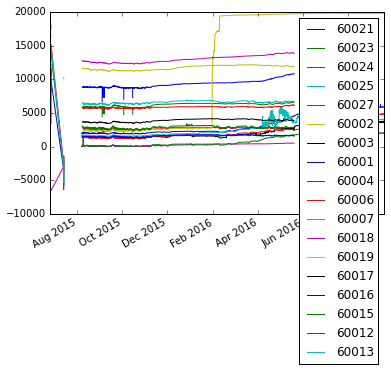

In [6]:
radius.plot()

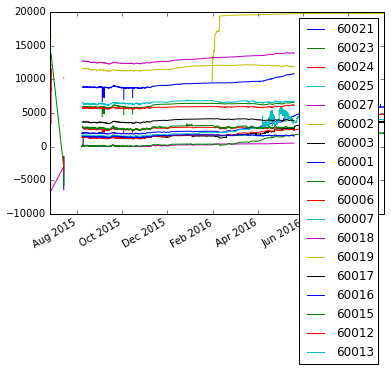

In [49]:
## Remove outliers
radiusMedian = radius.median()
radiusTrimmed = radius[(radius < (radiusMedian + 10000)) &
                (radius > (radiusMedian - 10000)) ]
radiusTrimmed.plot()

In [50]:
#%% SPECIFY TIME RANGE OF SERIES
startDateTime = pd.to_datetime('2016-09-16 00:00:00')
stopDateTime = pd.to_datetime('2016-09-17 00:00:00')
radiusTR = radiusTrimmed[(pd.to_datetime(radius.index) > startDateTime) & 
                (pd.to_datetime(radius.index) < stopDateTime)]


In [51]:
radiusTR.tail()

,60021,60023,60024,60025,60027,60002,60003,60001,60004,60006,60007,60018,60019,60017,60016,60015,60012,60013
2016-09-16 21:30:00,NaN,NaN,NaN,NaN,NaN,19821.2,3717.08,5873.2,2007.40,4762.0,4036.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-16 22:00:00,NaN,NaN,NaN,NaN,NaN,19821.2,3717.96,5874.4,2010.48,4763.6,4036.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-16 22:30:00,NaN,NaN,NaN,NaN,NaN,19821.6,3717.88,5877.2,2013.20,4765.6,4036.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-16 23:00:00,NaN,NaN,NaN,NaN,NaN,19821.6,3718.48,5877.2,2014.48,4766.4,4036.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-16 23:30:00,NaN,NaN,NaN,NaN,NaN,19822.0,3718.36,5878.8,2017.16,4767.6,4036.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
#1672 = cumulative WY precip, in mm
#1785 = Rainfall mm TB4 WSAM RWS_Rain_TB4_Tot2015-03-26 (ongoing)Rainfall mmAngelo Meadow WSwsam0 to 700TB4mm-L Rain Gage
#2958 = Barometric Pressure, WSSR, mBar
#2959 = Rainfall, WSSR, mm
#3048 = Rainfall Cumulative mm Sagehorn
# atmP = databaseQuery.odmquery(dateStart, dateStop, '2958', True)
# atmP.plot()
#rain = databaseQuery.odmquery(dateStart, dateStop, '2957', True)



In [53]:

#center to zero

radiusMin = radiusTR.apply(np.min)

radiusZeroed =  radiusTR-radiusMin



(0, 200)

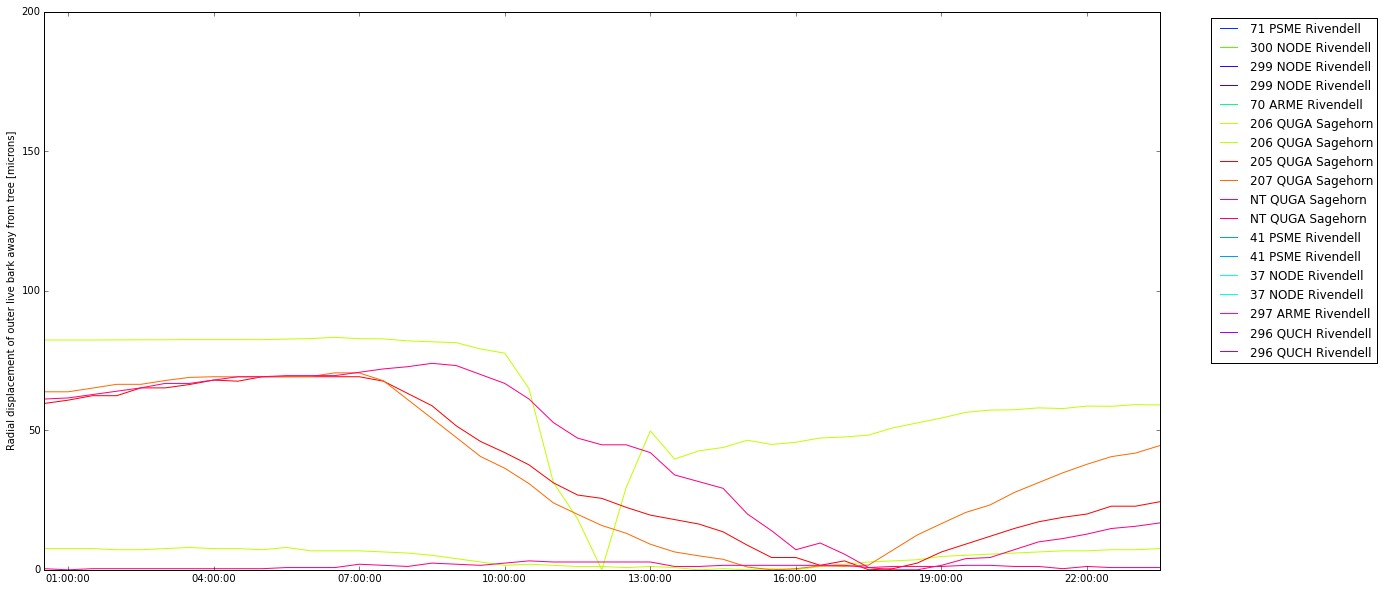

In [67]:
# fig, ax = plt.subplots(2, sharex=True, figsize=(17, 22))

fig = plt.figure(figsize=(20,10))
# Get unique names of species
uniq = list(set(metadata['Tree #']))

# Set the color map to match the number of species
# z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('hsv') )


for column in radiusZeroed:
#         plt.figure()
    ax = plt.plot(radiusZeroed.index, radiusZeroed[column], 
             color=scalarMap.to_rgba(uniq.index(Tree[column])), 
             label = (Tree[column] + ' ' + Species[column] + ' ' + Site[column]))
    plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylabel('Radial displacement of outer live bark away from tree [microns]')
plt.ylim([0,200])
#plt.savefig('pistonDendroDiurnal.pdf', format='pdf', bbox_inches='tight')

$$a + b / 3$$